In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utils
from simple_block import simple
import jacobian as jac

In [2]:
def rbc_ss(r=0.01, eis=1, frisch=1, delta=0.025, alpha=0.11):
    """Solve steady state of simple RBC model.
        
    Parameters
    ----------
    r      : scalar, real interest rate
    eis    : scalar, elasticity of intertemporal substitution (1/sigma)
    frisch : scalar, Frisch elasticity (1/nu)
    delta  : scalar, depreciation rate
    alpha  : scalar, capital share

    Returns
    -------
    ss : dict, steady state values
    """
    # solve for aggregates analytically
    rk = r + delta
    Z = (rk / alpha) ** alpha  # normalize so that Y=1
    K = (alpha * Z / rk) ** (1 / (1 - alpha))
    Y = Z * K ** alpha
    w = (1 - alpha) * Z * K ** alpha
    I = delta * K
    C = Y - I
    
    # preference params
    beta = 1 / (1 + r)
    vphi = w * C ** (-1 / eis)
    
    # check Walras's law
    walras = C - r * K - w
    assert np.abs(walras) < 1E-12

    return {'beta': beta, 'eis': eis, 'frisch':frisch, 'vphi': vphi, 'delta': delta, 'alpha': alpha,
            'Z': Z, 'K': K, 'I': I, 'Y': Y, 'L': 1, 'C': C, 'w': w, 'r': r, 'walras': walras}

In [3]:
ss = rbc_ss()
print(ss)

{'beta': 0.9900990099009901, 'eis': 1, 'frisch': 1, 'vphi': 0.9658914728682173, 'delta': 0.025, 'alpha': 0.11, 'Z': 0.8816460975214567, 'K': 3.1428571428571432, 'I': 0.07857142857142858, 'Y': 1.0, 'L': 1, 'C': 0.9214285714285714, 'w': 0.8900000000000001, 'r': 0.01, 'walras': -2.220446049250313e-16}


In [13]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

@simple
def household(K, L, w, eis, frisch, vphi, delta):
    C = (w / vphi / L ** (1 / frisch)) ** eis
    I = K - (1 - delta) * K(-1)
    return C, I

@simple
def mkt_clearing(r, C, Y, I, K, L, w, eis, beta):
    goods_mkt = Y - C - I
    euler = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)
    walras = C + K - (1 + r) * K(-1) - w * L  # we can the check dynamic version too
    return goods_mkt, euler, walras

In [14]:
G = jac.get_G(block_list=[firm, household, mkt_clearing],
              exogenous=['Z'],
              unknowns=['K', 'L'],
              targets=['euler', 'goods_mkt'],
              T=300, ss=ss)

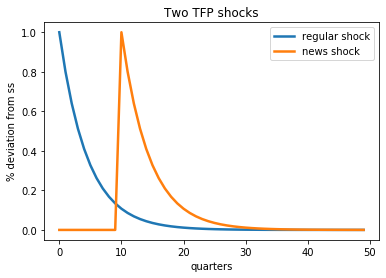

In [15]:
T, impact, rho, news = 300, 0.01, 0.8, 10
dZ = np.empty((T, 2))
dZ[:, 0] = impact * ss['Z'] * rho**np.arange(T)
dZ[:, 1] = np.concatenate((np.zeros(news), dZ[:-news, 0])) 

plt.plot(100*dZ[:50, 0]/ss['Z'], label='regular shock', linewidth=2.5)
plt.plot(100*dZ[:50, 1]/ss['Z'], label='news shock', linewidth=2.5)
plt.title(r'Two TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()

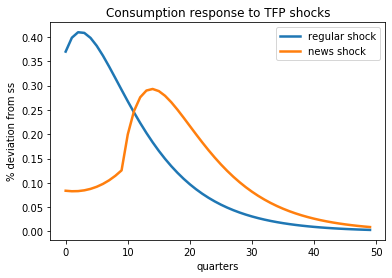

In [16]:
dC = 100 * G['C']['Z'] @ dZ / ss['C']
plt.plot(dC[:50, 0], label='regular shock', linewidth=2.5)
plt.plot(dC[:50, 1], label='news shock', linewidth=2.5)
plt.legend()
plt.title(r'Consumption response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

In [21]:
@simple
def mkt_clearing2(Z,r, C, Y, I, K, L, w, eis, beta, alpha, frisch, vphi, delta):
    r_res = r - alpha * Z * (K(-1) / L) ** (alpha-1) + delta
    w_res = w - (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y_res = Y - Z * K(-1) ** alpha * L ** (1 - alpha)
    C_res = C - (w / vphi / L ** (1 / frisch)) ** eis
    I_res = I - K + (1 - delta) * K(-1)
    goods_mkt = Y - C - I
    euler = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)
    walras = C + K - (1 + r) * K(-1) - w * L  # we can the check dynamic version too
    return r_res, w_res, Y_res, C_res, I_res, goods_mkt, euler, walras

In [22]:
G2 = jac.get_G(block_list=[mkt_clearing2],
              exogenous=['Z'],
              unknowns=['r','w','K', 'L','C','I','Y'],
              targets=['r_res', 'w_res', 'Y_res', 'C_res', 'I_res', 'euler', 'goods_mkt'],
              T=300, ss=ss)

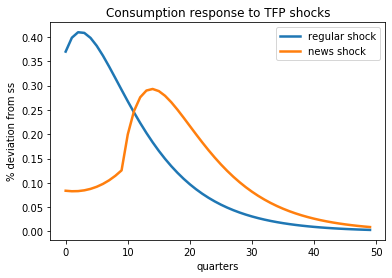

In [23]:
dC = 100 * G2['C']['Z'] @ dZ / ss['C']
plt.plot(dC[:50, 0], label='regular shock', linewidth=2.5)
plt.plot(dC[:50, 1], label='news shock', linewidth=2.5)
plt.legend()
plt.title(r'Consumption response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()